In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxpy as cp
import epopt as ep

# Forecasting wholesale electricity prices with multiple quantile regression

Introduction, basic idea

One paragraph summary of ERCOT energy markets (pull some stuff from annual report):
- Basic function of real-time vs. day-ahead market
- Include picture of Texas
- Location marginal pricing

Blah blah blah

## ERCOT market data

ERCOT publishes historical data for day-ahead and real time markets on its website at http://ercot.com/mktinfo/prices/index.html. 

In [185]:
prices = pd.read_csv(
    "ercot_2015.csv.gz",
    index_col=["Location", "Time"],
    converters={"Time": pd.to_datetime})
prices = prices.tz_localize("UTC", level=1).tz_convert("US/Central", level=1)

For settlement purposes, ERCOT aggregates the LMPs in 4 zones: North, South, West and Houston, a map is shown below.  

<img src="texas.png" width="30%"/>

The prices at each zone is determined by an average of the LMPs for nodes assigned to each zone. Typically the network is uncongested and the network constraints imposed by transmission limitations and non-binding resulting in prices that are the same across all zones. In the following figure we see that the maximum real-time price difference across the 4 zones is greater than \$10/MWh in less than 4% of the intervals observed in 2015 and we will focus on forecasting the real time price in this regime for the purposes of this notebook.

The occassions where prices vary wildly across zones are typically dominated by planned and unplanned anomalous events (e.g. transmission line failures, extreme weather, etc.). These situations are also important to understand and likely deserve a different model that attempts to explicitly forecast the occurence of such extreme events (as a side note, price differences across nodes have been securitized in the form of congestion revenue rights, see e.g. [Traders Lured to Bet on Power Overloads Worth Billions](http://www.bloomberg.com/news/articles/2014-08-14/traders-lured-to-bet-on-power-overloads-worth-billions)).

Fraction with >$1/MWh: 0.990211187215
Fraction with >$10/MWh: 0.975884703196
Fraction with >$100/MWh: 0.00970319634703
Fraction with >$1/MWh price difference: 0.188242009132
Fraction with >$10/MWh price difference: 0.0392694063927
Fraction with >$100/MWh price difference: 0.00245433789954


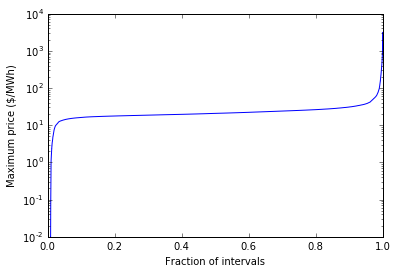

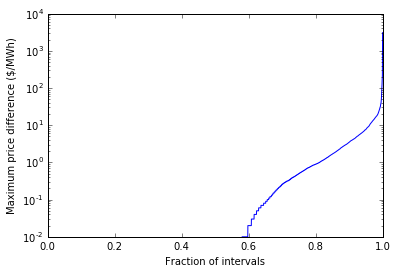

In [224]:
prices_by_zone = prices["Real-Time Price"].unstack(0)
max_price = prices_by_zone.max(axis=1)
min_price = prices_by_zone.min(axis=1)
max_diff = max_price - min_price
x = np.linspace(0, 1, len(prices_by_zone))

y = max_price.sort_values()
plt.semilogy(x, y)
plt.ylabel("Maximum price ($/MWh)")
plt.xlabel("Fraction of intervals")
print "Fraction with >$1/MWh:", np.sum(y > 1) / float(len(y))
print "Fraction with >$10/MWh:", np.sum(y > 10) / float(len(y))
print "Fraction with >$100/MWh:", np.sum(y > 100) / float(len(y))

plt.figure()
y = max_diff.sort_values()
plt.semilogy(x, y)
plt.ylabel("Maximum price difference ($/MWh)")
plt.xlabel("Fraction of intervals")
print "Fraction with >$1/MWh price difference:", np.sum(y > 1) / float(len(y))
print "Fraction with >$10/MWh price difference:", np.sum(y > 10) / float(len(y))
print "Fraction with >$100/MWh price difference:", np.sum(y > 100) / float(len(y))

In what follows we focus on forecasting the real-time price for the West zone which has the greatest amount of variability (due to wind power penetration). We also filter out extreme events of >\$100/MWh prices.

In [257]:
prices_west = prices.loc["HB_WEST"].loc[max_price < 100]

Here is a typical summer and winter week comparing the day-ahead price to the real-time price.

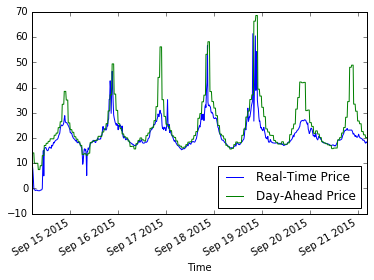

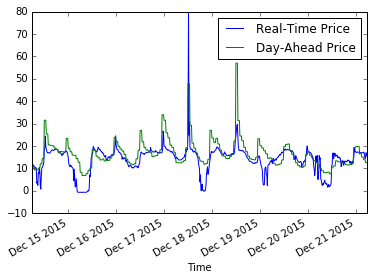

In [269]:
weeks = [slice("2015-09-14", "2015-09-20"),
         slice("2015-12-14", "2015-12-20")]

for week in weeks:
    prices_west[week].plot()

Quantitatively, we will compare a time series of prices using mean absolute error. As a starting point, the MAE between the day-ahead price and the real-time price is given by

In [270]:
def mae(x, y):
    return np.mean(np.abs(x - y))

print "MAE:", mae(prices_west["Real-Time Price"], prices_west["Day-Ahead Price"])

MAE: 4.98427291066


## Estimating the probability distribution

Our goal will be to build a model that produces an estimate of the *quantiles* for the real-time price. A straightforward method for doing so would be to simply use the empirical distribution conditioned on the hour-of-day as follows. 

In [ ]:
mae(prices

MAE: 4.61493804035


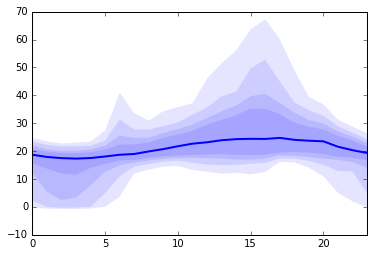

In [251]:
def plot_quantiles(x, quantiles, color, ax):
    k = quantiles.shape[1]
    for i in range(k/2):
        ax.fill_between(x, quantiles[:,i], quantiles[:,k-i-1], 
                        alpha=0.1, linewidth=0, facecolor=color)
        
coverages = [0.95, 0.9, 0.8, 0.65]
alphas = sorted([(1-x)/2 for x in coverages] +
                [1-(1-x)/2 for x in coverages] +
                [0.5])
k = len(alphas)
quantiles = prices_west["Real-Time Price"].groupby(lambda x: x.hour).quantile(alphas).unstack().as_matrix()

_, ax = plt.subplots()
x = range(24)
plot_quantiles(x, quantiles, "blue", ax)
ax.plot(x, quantiles[:,k/2], linewidth=2)
_ = plt.xlim([0, 23])
print "MAE:", mae(prices_west["Real-Time Price"], quantiles[prices_west.index.hour, k/2])

With this method we see that the median price in 2015 is relatively consistent near \$20/MWh and we capture the variability that occurs in the afternoon. For simplicitly, we summarize the accuracy of this model using the mean absolute error of the empirical median. In what follows we will develop a more sophisticated forecasting model which we will see improves on this metric while simultaneously estimating the distribution over future prices.

## Forecasting model 

Here we develop a basic forecasting models with two types of features:
- Periodic features for day, week, year  
- Autoregressive features for previous observed 
- Day-ahead price 

The goal of this forecasting model is to predict a day ahead-of-time (i.e. when bids are due for the day-ahead market), the real-time price. As such, the model only includes features that we can reasonably expect to observe in this scenario.

In [258]:
data = prices_west.copy()
data.columns = ["rt_price", "da_price"]

# Periodic time features
def minute_of_day(dt):
    return dt.hour/24. + dt.minute/24./60.
def hour_of_week(dt): 
    return dt.dayofweek/7. + dt.hour/7./24.    
def day_of_year(dt): 
    return dt.dayofyear/365.
    
time_features = [minute_of_day, hour_of_week, day_of_year]
for f in time_features:
    data[f.__name__ + "_cos"] = np.cos(f(data.index)*2*np.pi)
    data[f.__name__ + "_sin"] = np.sin(f(data.index)*2*np.pi)
    
# Autoregressive features
ar_features = [
    ("da_price", range(-12,0)),
    ("da_price", range(1,13)),
    ("rt_price", range(-47,-23))
]
for f, shifts in ar_features:
    for delta in shifts:
        data["%s_shift%+d" % (f, delta)] = data[f].shift(delta)
        
data = data.dropna()

from sklearn import linear_model
y = data.as_matrix(columns=["rt_price"])
X = data.as_matrix(columns=[x for x in data.columns if x != "rt_price"])
lr = linear_model.RidgeCV()
lr.fit(X,y)
print "MAE:", mae(lr.predict(X), y)

MAE: 3.70856043086


As can be seen above, a simple linear model improves significantly with the features over the naive estimator (the empirical median). Next, we will consider a nonlinear estimator by explicitly incorporating nonlinear feature transforms using radial-basis functions. First, we reduce the number of features to consider using a simple forward feature selection process: at each iteration we add the feature that most reduces the estimation error.

In [260]:
from sklearn import linear_model

# Forward feature selection
y = data.as_matrix(columns=["rt_price"])
features = set(data.columns)
features.remove("rt_price")
selected = set([])
for _ in range(20):
    best = (float("inf"), "")
    for f in features - selected:
        X = data.as_matrix(columns=selected.union([f]))
        lr = linear_model.RidgeCV(store_cv_values=True)
        lr.fit(X,y)
        score = np.min(np.mean(lr.cv_values_, axis=0))
        if score < best[0]:
            best = (score, f)
    print best
    selected.add(best[1])

(62.504268714424605, 'da_price')
(58.555533323226591, 'minute_of_day_sin')
(51.487197447237193, 'rt_price_shift-24')
(49.864444896063794, 'da_price_shift-8')
(49.062356576060246, 'minute_of_day_cos')
(48.014213087593696, 'rt_price_shift-47')
(47.319490784616328, 'da_price_shift+9')
(46.812685764461762, 'day_of_year_cos')
(46.620055742061183, 'day_of_year_sin')
(46.456541574331887, 'rt_price_shift-27')
(46.349432957271581, 'hour_of_week_cos')
(46.292870366817709, 'da_price_shift+12')
(46.246103824362919, 'rt_price_shift-42')
(46.217165579068386, 'da_price_shift+2')
(46.194863376737608, 'rt_price_shift-33')
(46.178536286346734, 'hour_of_week_sin')
(46.170181551098715, 'rt_price_shift-45')
(46.165017917578588, 'rt_price_shift-25')
(46.164427759207562, 'rt_price_shift-30')
(46.165687138175564, 'da_price_shift-12')


Now for each example we have a feature vector $x \in \mathbb{R}^n$ and we use this to build a nonlinear estimator by augmenting the features with radial basis functions (RBFs) taking the form
$$ \phi_j(x) = \exp\left(-\frac{\|x - \mu_j\|_2^2}{2 \sigma_j^2} \right) $$
where the parameter $\mu_j$ determines the center and $\sigma_j$ specifies the bandwidth of the $j$th RBF feature. In order to ensure that the radial basis functions cover the subset of the feature space, we choose the centers using K-Means clustering and the bandwidths using the median trick:
$$ \DeclareMathOperator*{\median}{median} \sigma_j = \median_{\ell \ne j} \| \mu_j - \mu_\ell\|_2 $$
In addition, in order to reduce computation time we fit the more sophisticated model on a 10% sample of the original dataset. This is simply expedient here as we have significantly more examples than features but in general more data will only increase performance (assuming overfitting is controlled, e.g. with cross-validation).

In [261]:
def sqdist(X, Y):
    """Squared euclidean distance for two sets of n-dimensional points"""
    return (
        np.tile(np.sum(X**2, axis=1), (Y.shape[0],1)).T + 
        np.tile(np.sum(Y**2, axis=1), (X.shape[0],1)) - 
        2*X.dot(Y.T))

X = data.as_matrix(columns=selected)
y = data.as_matrix(columns=["rt_price"])

# Normalize and sample data 
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
X_full, y_full = X, y
np.random.seed(0)
s = np.random.choice(X.shape[0], X.shape[0]/10)
X = X[s,:]
y = y[s]

# Use K-means to pick cluster centers
from sklearn import cluster
km = cluster.KMeans(n_clusters=1000, verbose=1, n_init=1, random_state=0)
km.fit(X)

# Median trick to pick bandwidth
mu = km.cluster_centers_
D = sqdist(mu, mu)
np.fill_diagonal(D, 0)
sigma = np.median(np.sqrt(D), axis=0)
def rbf(X):
    return np.exp(-sqdist(X, mu) / (2*sigma**2))

X_rbf = np.hstack((X, rbf(X)))
X_full_rbf = np.hstack((X_full, rbf(X_full)))

lr = linear_model.RidgeCV()
lr.fit(X_rbf, y)

print "MAE:", mae(y_full, lr.predict(X_full_rbf))


Initialization complete
Iteration  0, inertia 3127.451
Iteration  1, inertia 2232.125
Iteration  2, inertia 2186.868
Iteration  3, inertia 2178.030
Iteration  4, inertia 2177.182
Converged at iteration 4
MAE: 3.14760616416


## Least absolute deviations

So far in the development of our forecasting model we have focused on feature selection and simply employed the ordinary least squares model with $\ell_2$-regularization (also known as ridge regression). In particular the `sklearn` method we have been using fits the parameters $\theta$ by solving the optimization problem
$$ \DeclareMathOperator{\minimize}{minimize} \minimize \;\; (1/2) \|X\theta - y\|_2^2 + \lambda \|\theta\|_2^2 $$
where $X$ and $y$ are the training data. However, in this problem our error metric is actually the $\ell_1$ loss and so we can get better performance by minimizing that function directly. In addition, since we have significantly expanded the number of features using RBFs, it makes sense to employ some $\ell_1$-regularization in order to fit a sparse model. Putting these ideas together, our new optimization problem is
$$ \minimize \;\; \|X\theta - y\|_1 + \lambda \|\theta\|_1 $$
In order to fit this model we employ [CVXPY](http://cvxpy.org) and [Epsilon](http://epopt.io) which allows us to specify the optimization problem directly.

In [290]:
def nz(x):
    return np.sum(np.abs(x) > 1e-4) / float(x.size)

# Setup data
X = X_rbf
y = np.ravel(y)
X_full = X_full_rbf

# Parameters
m, n = X.shape
lam = 1e-1
theta = cp.Variable(n)

# Estimation
f = cp.norm1(X*theta - y) + lam*cp.norm1(theta)
prob = cp.Problem(cp.Minimize(f))
ep.solve(prob, rel_tol=1e-3)

print "MAE:", mae(y_full, X_full_rbf.dot(theta.value))
print "nonzero:", nz(theta.value)

MAE: 2.95889509386
nonzero: 0.447058823529


With our new model, we can compare our predicted real-time price to the actual real-time price and see qualitatively that improves significantly over the day-ahead price. In theory, we could employ such a model to make virtual bids in the Ercot and others (e.g. CAISO refers to this practice as [convergence bidding](https://www.caiso.com/1807/1807996f7020.html)).

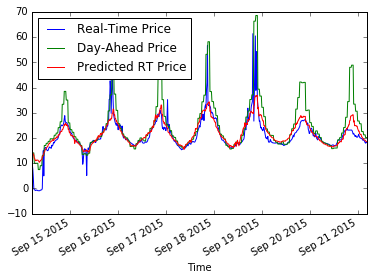

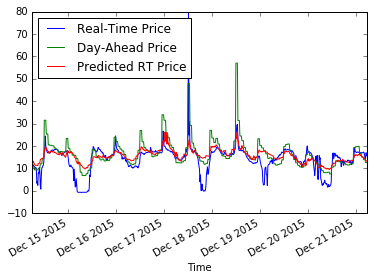

In [276]:
compare = pd.DataFrame()
compare["Real-Time Price"] = data["rt_price"]
compare["Day-Ahead Price"] = data["da_price"]
compare["Predicted RT Price"] = X_full_rbf.dot(theta.value)

for week in weeks:
    compare[week].plot()

## Multiple quantile regression

However, clearly there is a large amount of intrinsic variability in the real-time price and thus we would like to forecast not just a point estimate of the future price at each interval but in fact a probability distribution over future prices. Our method will be to represent a distribution by its quantiles and for each interval we will produce an estimate $\hat{y}_\alpha$ corresponding to the $\alpha$-quantile of $y$. We will simultaneously estimate quantiles for all $\alpha$ in some set $\mathcal{A}$ by minimizing the loss function
$$
\ell(\hat{y}_\mathcal{A}, y) = \sum_{\alpha \in \mathcal{A}} \psi_\alpha(\hat{y}_\alpha - y)
$$
where $\psi_\alpha$ is the asymmetric absolute loss
$$
\psi_\alpha(z) = \max \{\alpha z, (\alpha - 1)z\}.
$$
In estimating the parameters with this new loss function we will maintain the $\ell_1$-penalty to encourage sparsity.

With standard statistical software, replacing the loss function would require a new package to be developed, new numerical algorithms to be studied and implemented, requiring significant effort. However, in the declarative model provided by CVXPY/Epsilon, this modification is straightforward. The main change necessary is to write the quantile loss function as a series of numpy matrix operations. One way to do this is as follows:

In [277]:
def quantile_loss(alphas, Theta, X, y):
    m, n = X.shape
    k = len(alphas)
    Y = np.tile(y, (k, 1)).T
    A = np.tile(alphas, (m, 1))
    Z = X*Theta - Y
    return cp.sum_entries(
        cp.max_elemwise(
            cp.mul_elemwise( -A, Z),
            cp.mul_elemwise(1-A, Z)))

Then, we simply specify the desired and quantiles and substitute this function in place of our existing least absolute deviations term

In [292]:
# Desired coverage and quantiles
coverages = [0.95, 0.9, 0.8, 0.65]
alphas = sorted([(1-x)/2 for x in coverages] +
                [1-(1-x)/2 for x in coverages] +
                [0.5])

# Parameters
k = len(alphas)
lam = 1e-1
Theta = cp.Variable(n,k)

# Estimation
f = quantile_loss(alphas, Theta, X, y) + lam*cp.norm1(Theta)
prob = cp.Problem(cp.Minimize(f))
ep.solve(prob, rel_tol=1e-3)

print "MAE:", mae(y_full, X_full.dot(Theta.value[:,k/2]))
print "nonzero:", nz(Theta.value)

MAE: 2.96578568418
nonzero: 0.22211328976


Finally, we visualize the forecasted distribution over prices on the original two weeks showing that there is a significantly higher probability of price spikes in the afternoon during summer than in winter. 

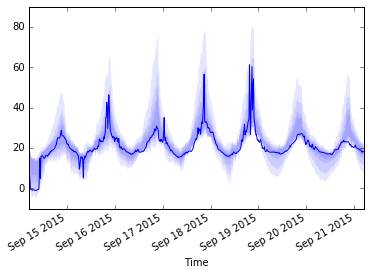

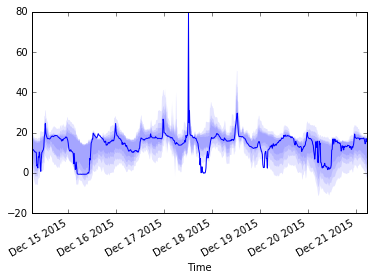

In [296]:
quantiles = pd.DataFrame(X_full.dot(Theta.value), index=data.index)

def plot_price_and_quantiles(idx):
    _, ax = plt.subplots()
    data[idx]["rt_price"].plot(ax=ax)
    plot_quantiles(data[idx].index, quantiles[idx].as_matrix(), "blue", ax)

plot_price_and_quantiles(slice("2015-09-14", "2015-09-20"))
plot_price_and_quantiles(slice("2015-12-14", "2015-12-20"))

We can also zoom into to get a more detailed view of how the price distribution evolves over the period of a single day.

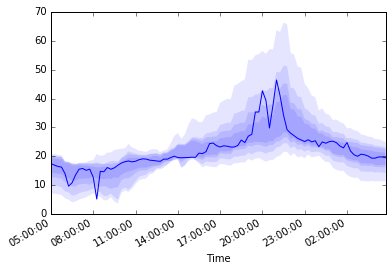

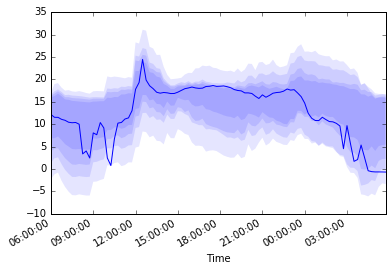

In [297]:
plot_price_and_quantiles("2015-09-15")
plot_price_and_quantiles("2015-12-14")

## Final notes

Talk about
- proper cross validation
- predicting anomalous events
